Doc2vec from scratch in PyTorch
===============================

Here we are implementing this useful algorithm with a library we know and trust. With luck this will be more accessible than reading the papers but more in-depth than typical "install gensim and just do what I say" tutorials. This is all based on the great work by [Nejc Ilenic](https://github.com/ilenic/paragraph-vectors) and reading the referenced papers.

As every schoolchild knows, the basic form of `word2vec` (and so `doc2vec`) is that it is a classifier trained to predict the missing word in a context. So given sentences like "the cat _ on the mat" it should predict "sat", and so learn a useful representation of words. We can then extract the weights of its output layer and re-use them as "word embeddings", vectors giving each word a position in N-dimensional space that is hopefully close to similar words and an appropriate distance from related words. 

`doc2vec` or "Paragraph vectors" extends the `word2vec` idea by simply adding a document id to each context. This helps the network learn associations between contexts (but of course produces less generalizable vectors).

First we need to load the data.

In [1]:
import pandas as pd
import spacy

nlp = spacy.load("en_core_web_sm")

df = pd.read_csv("data/example.csv")
df["tokens"] = df.text.str.lower().apply(lambda x: [token.text for token in nlp(x)])

df[:3]

,text,tokens
0,"In the week before their departure to Arrakis,...","[in, the, week, before, their, departure, to, ..."
1,"It was a warm night at Castle Caladan, and the...","[it, was, a, warm, night, at, castle, caladan,..."
2,The old woman was let in by the side door down...,"[the, old, woman, was, let, in, by, the, side,..."


We will need to construct a vocabulary.

In [2]:
from collections import Counter

class Vocab:
    def __init__(self, all_tokens):
        self.freqs = Counter(all_tokens)
        self.words = sorted(self.freqs.keys())
        self.word2idx = {w: i for i, w in enumerate(self.words)}
        
vocab = Vocab([tok for tokens in df.tokens for tok in tokens])

The difficulty with our "the cat _ on the mat" problem is that the missing word could be any one in the vocabulary V and so the network would have |V| outputs for each input e.g. a huge vector containing zero for every word in the vocabulary and some positive number for "sat" if the network was perfectly trained. For calculating loss we need to turn that into a probabilty distribution, i.e. _softmax_ it. Computing the softmax for such a large vector is expensive.

So the trick (one of many possible) we will use is _Noise Contrastive Estimation (NCE)_. We change our "the cat _ on the mat" problem into a multiple choice problem, asking the network to choose between "sat" and some random wrong answers like "hopscotch" and "luxuriated". This is easier to compute the softmax for since the output is simply of a vector of size 1 + k where k is the number of random incorrect options.

Happily, this alternative problem still learns equally useful word representations. We just need to adjust the examples and the loss function. There is a simplified version of the NCE loss function called _Negative Sampling (NEG)_ that we can use here.

[Notes on Noise Contrastive Estimation and Negative Sampling (C. Dyer)](https://arxiv.org/abs/1410.8251) explains the NCE and NEG loss functions.

The general idea is to create a set of examples where each example has:

- doc id
- target noise ids - a collection of the target token and some noise tokens
- context ids - tokens before and after the target token

e.g. If our context size was 2, the first example from the above dataset would be:

```
{"doc_id": 0,
 "target_noise_ids": [word2idx[x] for x in ["week", "random-word-from-vocab", "random-word-from-vocab"...],
 "context_ids": [word2idx[x] for x in ["in", "the", "before", "their"]]}
 ```
 
 The random words are chosen according to a probability distribution:
 
 > a unigram distribution raised to the 3/4rd power, as proposed by T. Mikolov et al. in Distributed Representations of Words and Phrases and their Compositionality

This has the effect of slightly increasing the probability of rare words (look at the graph of `y=x^0.75` below and see how the lower end is raised above `y=x`).

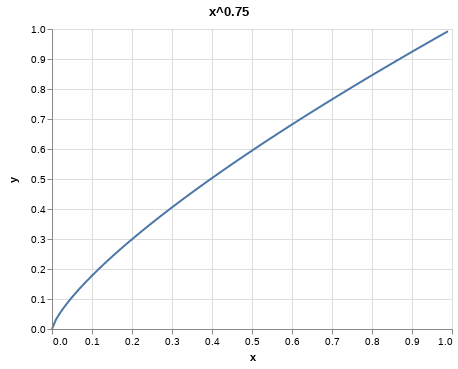

In [3]:
import altair as alt
import numpy as np

data = pd.DataFrame(zip(np.arange(0,1,0.01), np.power(np.arange(0,1,0.01), 0.75)), columns=["x", "y"])
alt.Chart(data, title="x^0.75").mark_line().encode(x="x", y="y")

In [4]:
import numpy as np

class NoiseDistribution:
    def __init__(self, vocab):
        self.probs = np.array([vocab.freqs[w] for w in vocab.words])
        self.probs = np.power(self.probs, 0.75)
        self.probs /= np.sum(self.probs)
    def sample(self, n):
        "Returns the indices of n words randomly sampled from the vocabulary."
        return np.random.choice(a=self.probs.shape[0], size=n, p=self.probs)
        
noise = NoiseDistribution(vocab)

With this distribution, we advance through the documents creating examples.

In [5]:
import torch

def example_generator(df, context_size, noise, n_noise_labels, vocab):
    for doc_id, doc in df.iterrows():
        for i in range(context_size, len(doc.tokens) - context_size):
            true_label = doc.tokens[i]
            labels = noise.sample(n_noise_labels).tolist()
            labels.insert(0, vocab.word2idx[true_label])
            context = doc.tokens[i - context_size:i] + doc.tokens[i + 1:i + context_size + 1]
            context_ids = [vocab.word2idx[w] for w in context]
            yield {"doc_ids": torch.tensor(doc_id),  # we use plural here because it will be batched
                   "label_ids": torch.tensor(labels), 
                   "context_ids": torch.tensor(context_ids)}
            
examples = example_generator(df, context_size=5, noise=noise, n_noise_labels=15, vocab=vocab)

And package this up as a PyTorch dataset.

In [6]:
from torch.utils.data import Dataset, DataLoader

class NCEDataset(Dataset):
    def __init__(self, examples):
        self.examples = list(examples)  # just naively evaluate the whole damn thing - suboptimal!
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, index):
        return self.examples[index]
    
dataset = NCEDataset(examples)
dataloader = DataLoader(dataset, batch_size=2)  # TODO bigger batch size when not dummy data

Let's jump into creating the model now.

In [39]:
import torch.nn as nn

class DistributedMemory(nn.Module):
    def __init__(self, vec_dim, n_docs, n_words):
        super(DistributedMemory, self).__init__()
        self.paragraph_matrix = nn.Parameter(torch.randn(n_docs, vec_dim))
        self.word_matrix = nn.Parameter(torch.randn(n_words, vec_dim))
        self.outputs = nn.Parameter(torch.zeros(vec_dim, n_words))
    
    def forward(self, doc_ids, context_ids, label_ids):
                                                                               # first add doc ids to context word ids to make the inputs
        inputs = torch.add(self.paragraph_matrix[doc_ids,:],                   # (batch_size, vec_dim)
                           torch.sum(self.word_matrix[context_ids,:], dim=1))  # (batch_size, 2x context, vec_dim) -> sum to (batch_size, vec_dim)
                                                                               #
                                                                               # select the subset of the output layer for the NCE test
        outputs = self.outputs[:,label_ids]                                    # (vec_dim, batch_size, n_noise_labels + 1)
                                                                               #
        return torch.bmm(inputs.unsqueeze(dim=1),                              # then multiply with some munging to make the tensor shapes line up 
                         outputs.permute(1, 0, 2)).squeeze()                   # -> (batch_size, n_noise_labels + 1)

model = DistributedMemory(vec_dim=300,
                          n_docs=len(df),
                          n_words=len(vocab.words))

In [40]:
model.forward(**next(iter(dataloader)))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       grad_fn=<SqueezeBackward0>)